# Understanding Customer Behavior through Sales Data

This project involves statistical analysis of the Supermarket Sales dataset to extract insights into customer behavior. Exploratory data analysis and K-Means clustering techniques are applied to identify distinct consumer segments, providing valuable information to support strategic business decisions.

The Supermarket Sales dataset includes the following key columns:

* *Invoice ID* – Unique identifier for each transaction.

* *Branch* – Store branch code (A, B, or C).

* *City* – City where the store is located (e.g., Yangon, Naypyitaw, Mandalay).

* *Customer type* – Type of customer: Member (loyalty program) or Normal (walk-in customer).

* *Gender* – Gender of the customer (Male or Female).

* *Product line* – Category of the product purchased (e.g., Health & Beauty, Food & Beverages, Electronic Accessories, etc.).

* *Unit price* – Price per unit of the product.

* *Quantity* – Number of items purchased in the transaction.

* *Tax 5%* – 5% tax applied to the total before tax.

* *Sales* – Total amount paid by the customer (includes tax).

* *Date* – Date when the transaction took place.

* *Time* – Time when the transaction occurred.

* *Payment* – Payment method used (e.g., Cash, Credit Card, Ewallet).

* *COGS* – Cost of Goods Sold; subtotal before tax (raw cost of the products)

* *Gross margin percentage* – Fixed margin percentage on COGS (in this dataset, it’s consistently 4.7619%).

* *Gross income* – Profit earned from the transaction.

* *Rating* – Customer satisfaction rating, ranging from 4 to 10.



---



## Libraries

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import warnings
#from helper import assign_time_period, find_outliers

## Import dataset

In [138]:
# from google.colab import files
# uploaded = files.upload()

In [139]:
path = 'D:\\PythonProjects\\Dataset\\SuperMarket Analysis.csv'
df = pd.read_csv(path)
print(f"Rows, Columns: {df.shape}\n")
print(df.info())
df.head()
from IPython.display import HTML
HTML("<div style='overflow-x: auto'>" + df.head().to_html() + "</div>")


Rows, Columns: (1000, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Sales                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


## Pre-processing

### Null values and duplicate analysis

In [142]:
print("Are there duplicate values? ", df.duplicated().any())
print("Are there null values? ", df.isnull().values.any())

Are there duplicate values?  False
Are there null values?  False


### Features analysis

In [144]:
print(df.dtypes)

Invoice ID                  object
Branch                      object
City                        object
Customer type               object
Gender                      object
Product line                object
Unit price                 float64
Quantity                     int64
Tax 5%                     float64
Sales                      float64
Date                        object
Time                        object
Payment                     object
cogs                       float64
gross margin percentage    float64
gross income               float64
Rating                     float64
dtype: object


In [145]:
# Find the unique values for each non-numeric column
for col in df.drop(columns = ['Invoice ID','Date','Time']).select_dtypes(include='object').columns:
    print(f"\nColumn: {col}")
    print(f"Unique values ({df[col].nunique()}): {df[col].unique()}")


Column: Branch
Unique values (3): ['Alex' 'Giza' 'Cairo']

Column: City
Unique values (3): ['Yangon' 'Naypyitaw' 'Mandalay']

Column: Customer type
Unique values (2): ['Member' 'Normal']

Column: Gender
Unique values (2): ['Female' 'Male']

Column: Product line
Unique values (6): ['Health and beauty' 'Electronic accessories' 'Home and lifestyle'
 'Sports and travel' 'Food and beverages' 'Fashion accessories']

Column: Payment
Unique values (3): ['Ewallet' 'Cash' 'Credit card']


In [146]:
print('Branch-City 1:1 relationship: \n' , df[['Branch','City']].drop_duplicates())

Branch-City 1:1 relationship: 
   Branch       City
0   Alex     Yangon
1   Giza  Naypyitaw
9  Cairo   Mandalay


### Data time preprocessing

In [148]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'],  format = '%m/%d/%Y')

# Extract day name (e.g., Monday, Tuesday, etc.)
df['DayOfWeek'] = df['Date'].dt.day_name()

# Convert the 'Time' column to datetime format
warnings.filterwarnings("ignore", category=UserWarning)
df['Time'] = pd.to_datetime(df['Time'])

# Extract the hour
df['Hour'] = df['Time'].dt.hour

# Assign the time of day
def assign_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour <= 24:
        return 'Evening'

# Apply
df['TimeOfDay'] = df['Hour'].apply(assign_time_period)

df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating,DayOfWeek,Hour,TimeOfDay
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,2025-07-04 13:08:00,Ewallet,522.83,4.761905,26.1415,9.1,Saturday,13,Afternoon
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,2025-07-04 10:29:00,Cash,76.40,4.761905,3.8200,9.6,Friday,10,Morning
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,2025-07-04 13:23:00,Credit card,324.31,4.761905,16.2155,7.4,Sunday,13,Afternoon
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,2025-07-04 20:33:00,Ewallet,465.76,4.761905,23.2880,8.4,Sunday,20,Evening
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,2025-07-04 10:37:00,Ewallet,604.17,4.761905,30.2085,5.3,Friday,10,Morning


## Descriptive analysis

### Summary statistics (numerical variables)

In [151]:
df.describe()

,Unit price,Quantity,Tax 5%,Sales,Date,Time,cogs,gross margin percentage,gross income,Rating,Hour
count,1000.000000,1000.000000,1000.000000,1000.000000,1000,1000,1000.00000,1.000000e+03,1000.000000,1000.00000,1000.000000
mean,55.672130,5.510000,15.379369,322.966749,2019-02-14 00:05:45.600000,2025-07-04 15:24:41.880000,307.58738,4.761905e+00,15.379369,6.97270,14.910000
min,10.080000,1.000000,0.508500,10.678500,2019-01-01 00:00:00,2025-07-04 10:00:00,10.17000,4.761905e+00,0.508500,4.00000,10.000000
25%,32.875000,3.000000,5.924875,124.422375,2019-01-24 00:00:00,2025-07-04 12:43:00,118.49750,4.761905e+00,5.924875,5.50000,12.000000
50%,55.230000,5.000000,12.088000,253.848000,2019-02-13 00:00:00,2025-07-04 15:19:00,241.76000,4.761905e+00,12.088000,7.00000,15.000000
75%,77.935000,8.000000,22.445250,471.350250,2019-03-08 00:00:00,2025-07-04 18:15:00,448.90500,4.761905e+00,22.445250,8.50000,18.000000
max,99.960000,10.000000,49.650000,1042.650000,2019-03-30 00:00:00,2025-07-04 20:59:00,993.00000,4.761905e+00,49.650000,10.00000,20.000000
std,26.494628,2.923431,11.708825,245.885335,NaN,NaN,234.17651,6.131498e-14,11.708825,1.71858,3.186857


**Key observations:**

   



*   The dataset collects customer purchases made in **2019**, specifically during the period from **January 1st to March 30th**.

*   The preliminary analysis reveals that **Sales** exhibit high variability, primarily driven by fluctuations in Unit price.

*   Similarly, the **Cost of Goods Sold** (COGS) shows significant variability.


*   Both **Sales** and **COGS** are crucial in directly determining the Gross Income.







### Quantitative variable distribution analysis

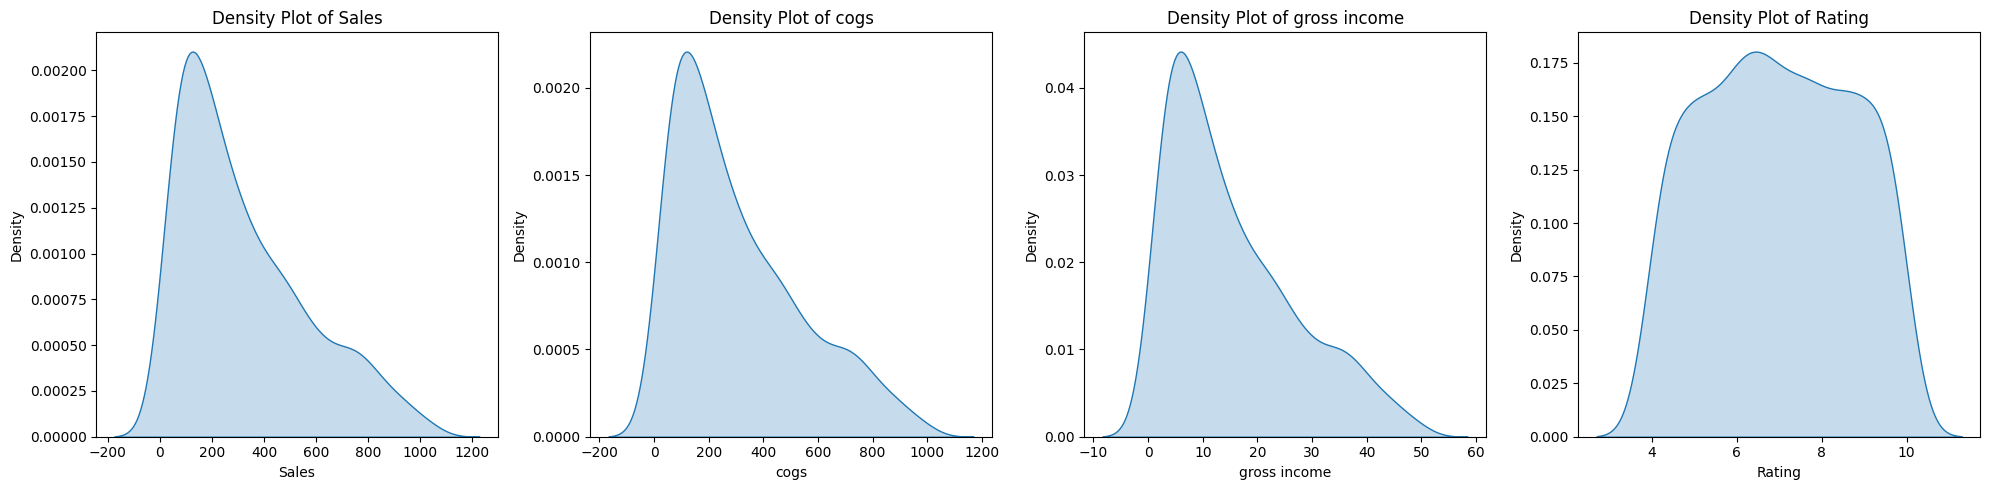

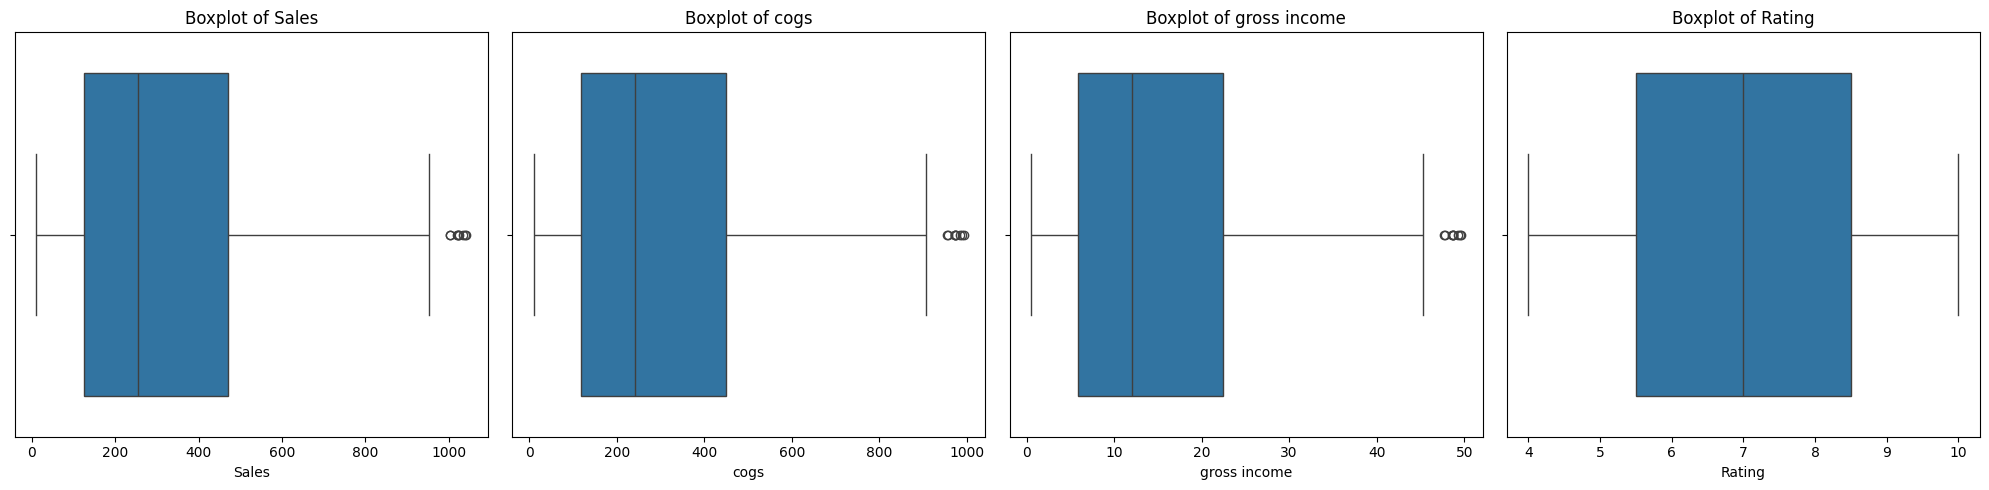

In [154]:
variables = ['Sales', 'cogs', 'gross income', 'Rating']

# Density plots in a 1x4 grid
plt.figure(figsize=(20,5))
for i, var in enumerate(variables, 1):
    plt.subplot(1, 4, i)
    sns.kdeplot(df[var], fill=True)
    plt.title(f'Density Plot of {var}')
    plt.xlabel(var)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Boxplots in a 1x4 grid
plt.figure(figsize=(20,5))
for i, var in enumerate(variables, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot of {var}')
    plt.xlabel(var)
plt.tight_layout()
plt.show()


**Key Observations**

* The distribution of **Sales** is **right-skewed**, indicating that most profits fall below the average, with only a few transactions generating very high profits.
*   As anticipated, the distribution of **Gross Income** aligns with that of **Sales** and **Cost of Goods Sold** (COGS), reflecting their direct relationship. Furthermore, the boxplot analysis for these variables highlights the presence of several outliers.

*   In contrast, the **Rating** distribution exhibits a high degree of symmetry.








### Quantitative variable outliers analysis

In [157]:
# Extract the outliers
def find_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

# Apply
outliers_sales = find_outliers(df, 'Sales')
outliers_income = find_outliers(df, 'gross income')
print(f"Outliers for 'Sales':")
print(outliers_sales)
print(f"Number of outliers: {len(outliers_sales)}\n")
print(f"Outliers for 'gross income':")
print(outliers_income)
print(f"Number of outliers: {len(outliers_income)}\n")

Outliers for 'Sales':
      Invoice ID Branch       City Customer type  Gender         Product line  \
166  234-65-2137   Giza  Naypyitaw        Normal    Male   Home and lifestyle   
167  687-47-8271   Alex     Yangon        Normal    Male  Fashion accessories   
350  860-79-0874   Giza  Naypyitaw        Member  Female  Fashion accessories   
357  554-42-2417   Giza  Naypyitaw        Normal  Female    Sports and travel   
422  271-88-8734   Giza  Naypyitaw        Member  Female  Fashion accessories   
557  283-26-5248   Giza  Naypyitaw        Member  Female   Food and beverages   
699  751-41-9720   Giza  Naypyitaw        Normal    Male   Home and lifestyle   
792  744-16-7898  Cairo   Mandalay        Normal  Female   Home and lifestyle   
996  303-96-2227  Cairo   Mandalay        Normal  Female   Home and lifestyle   

     Unit price  Quantity  Tax 5%     Sales       Date                Time  \
166       95.58        10  47.790  1003.590 2019-01-16 2025-07-04 13:32:00   
167       9

**Key observations**

The outliers in Sales and Gross Income originate from the same observations. This outcome is expected, given that Gross Income is directly derived from the Sales amount.



In [159]:
# Outliers by categorical variables
variables = ['DayOfWeek','Hour','Customer type','Gender','Payment','Product line']

print(outliers_sales.groupby(['City','TimeOfDay']).size().sort_values(ascending=False), '\n')
for var in variables:
  print(outliers_sales[var].value_counts(ascending=False), '\n')

City       TimeOfDay
Naypyitaw  Afternoon    5
Mandalay   Afternoon    2
Naypyitaw  Evening      1
Yangon     Afternoon    1
dtype: int64 

DayOfWeek
Wednesday    3
Friday       3
Saturday     2
Tuesday      1
Name: count, dtype: int64 

Hour
13    4
16    2
14    1
20    1
17    1
Name: count, dtype: int64 

Customer type
Normal    6
Member    3
Name: count, dtype: int64 

Gender
Female    6
Male      3
Name: count, dtype: int64 

Payment
Credit card    4
Ewallet        3
Cash           2
Name: count, dtype: int64 

Product line
Home and lifestyle     4
Fashion accessories    3
Sports and travel      1
Food and beverages     1
Name: count, dtype: int64 



**Key observations:**



*   These high-value transactions occurred most frequently on **Wednesdays** and **Fridays**, primarily during the **afternoon**, with peaks observed in post-lunch hours.

*   Geographically, a significant portion originated from **Naypyitaw**.

*   Demographically, **female** customers accounted for the majority of these purchases.

*   Interestingly, most were made by **non-members**, highlighting a potential area of inefficiency within the loyalty program.

*   As for payment, the **credit card** was the most frequently used method, possibly due to its deferred payment capability.

*   Finally, the dominant product categories among these outlier purchases were **Home and Lifestyle** and **Fashion Accessories**.

In [161]:
# Extract the Sales values in the quantiles 0.90 to 0.99

for i in range(90, 100, 1):
  pct_i = df['Sales'].quantile(i/100)
  pct_prev = df['Sales'].quantile((i-1)/100)
  delta = round(pct_i - pct_prev, 2)
  print(f"Percentile: {i}")
  print(f"Sales: {round(df['Sales'].quantile(i/100), 2)}")
  print(f"Delta: {delta}\n")

Percentile: 90
Sales: 718.91
Delta: 21.48

Percentile: 91
Sales: 734.13
Delta: 15.22

Percentile: 92
Sales: 749.94
Delta: 15.8

Percentile: 93
Sales: 769.27
Delta: 19.33

Percentile: 94
Sales: 793.77
Delta: 24.5

Percentile: 95
Sales: 822.5
Delta: 28.72

Percentile: 96
Sales: 836.57
Delta: 14.08

Percentile: 97
Sales: 874.34
Delta: 37.77

Percentile: 98
Sales: 931.06
Delta: 56.72

Percentile: 99
Sales: 950.27
Delta: 19.2



**Understanding the results:**

The sales outliers, while representing the top 1% of transactions, aren't excessively far from the 99th percentile. Moreover, the increase in these most extreme percentiles remains quite stable, hovering around 20-30%. This suggests we can reasonably consider these transactions as realistic.

### Correlation Matrix

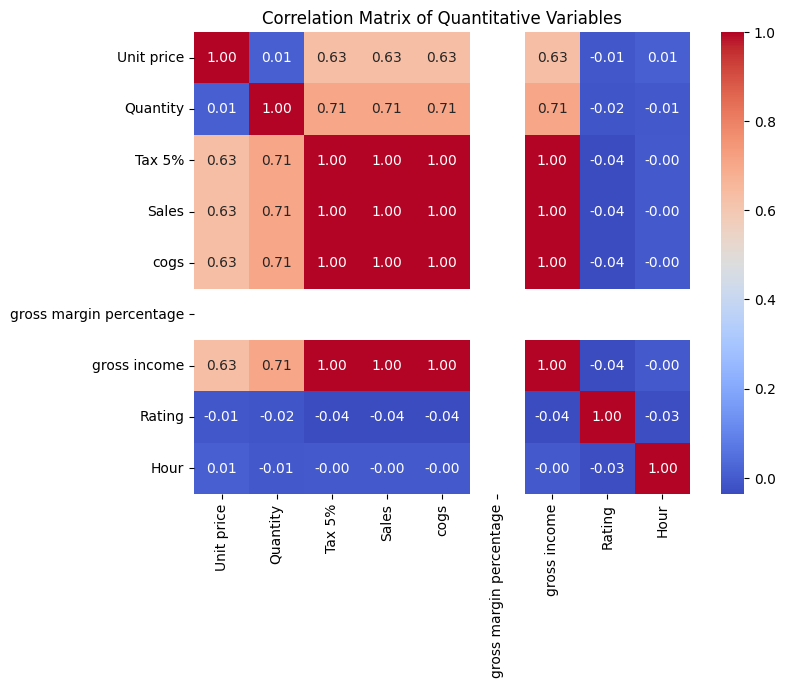

In [164]:
# Select only numerical columns from the DataFrame
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for these numerical columns
correlation_matrix = numeric_df.corr()
#print(correlation_matrix)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Quantitative Variables')
plt.show()

**Understanding the results:**

*   Surprisingly, **Quantity and Price** show almost no correlation, which goes against the expected negative relationship. This suggests that customers' purchasing habits aren't significantly affected by price changes.

*   As anticipated, **Sales and COGS** are highly and positively correlated with both price and quantity, a natural outcome given their linear dependence on these variables.

*   Lastly, **Rating** doesn't exhibit any strong correlations that would offer useful insights.









### Frequency analysis

In [167]:
# Select only the categorical variables
categorical_var = df.drop(columns = 'Invoice ID').select_dtypes(include='object').columns

# Calculate the relative frequency
for var in categorical_var:
  freq_abs = df[var].value_counts(normalize = True)*100
  print(f'Relative frequency: {freq_abs} \n')

# Show the mode
print('Mode')
for var in categorical_var:
  print(f'{var}: {list(df[var].mode())}')


Relative frequency: Branch
Alex     34.0
Cairo    33.2
Giza     32.8
Name: proportion, dtype: float64 

Relative frequency: City
Yangon       34.0
Mandalay     33.2
Naypyitaw    32.8
Name: proportion, dtype: float64 

Relative frequency: Customer type
Member    56.5
Normal    43.5
Name: proportion, dtype: float64 

Relative frequency: Gender
Female    57.1
Male      42.9
Name: proportion, dtype: float64 

Relative frequency: Product line
Fashion accessories       17.8
Food and beverages        17.4
Electronic accessories    17.0
Sports and travel         16.6
Home and lifestyle        16.0
Health and beauty         15.2
Name: proportion, dtype: float64 

Relative frequency: Payment
Ewallet        34.5
Cash           34.4
Credit card    31.1
Name: proportion, dtype: float64 

Relative frequency: DayOfWeek
Saturday     16.4
Tuesday      15.8
Wednesday    14.3
Friday       13.9
Thursday     13.8
Sunday       13.3
Monday       12.5
Name: proportion, dtype: float64 

Relative frequency: Tim

**Understanding the result:**

*   **Balanced Sales Across Locations**: Sales activity is well distributed geographically, with branches and cities showing nearly equal representation.

*   **Loyalty Program Insights**: While most transactions are from loyalty program members, interestingly, most high-value (outlier) purchases are made by non-members. This suggests the loyalty program might not be effectively engaging or rewarding its top-spending customers.

*   **Demographics**: Female customers account for the majority of overall transactions, a trend consistent with their prevalence among outlier purchases.

*   **Product Preferences**: Sales are fairly even across product lines. Fashion Accessories lead slightly, a trend also observed in the outlier analysis.

*   **Time of Purchase**: Transactions are more frequent in the afternoon and evening, supporting the pattern found among outlier purchases.

*   **Payment Methods**: Payment preferences are quite balanced. E-wallets are slightly more common, while Credit Cards are the least used overall. This reinforces the idea that high-value customers might prefer credit cards for their flexibility or deferred payment options when making larger expenditures.

*   **Weekday Patterns**: Customer demand remains steady throughout the week with minor fluctuations. Monday is the least active day, and Saturday the most active, aligning with typical shopping behavior where people shop less at the start of the workweek and more on their days off.






### Single-variable exploration

In [170]:
var = ['City', 'Customer type', 'Gender', 'Product line', 'Payment', 'DayOfWeek', 'TimeOfDay']

for i in var:
  print(df.groupby(i)['Sales'].mean().sort_values(ascending=False),'\n')

City
Naypyitaw    337.099715
Mandalay     319.872506
Yangon       312.354031
Name: Sales, dtype: float64 

Customer type
Member    335.742945
Normal    306.372379
Name: Sales, dtype: float64 

Gender
Female    340.931414
Male      299.055738
Name: Sales, dtype: float64 

Product line
Home and lifestyle        336.636956
Sports and travel         332.065220
Health and beauty         323.643020
Food and beverages        322.671517
Electronic accessories    319.632538
Fashion accessories       305.089298
Name: Sales, dtype: float64 

Payment
Cash           326.181890
Credit card    324.009878
Ewallet        318.820600
Name: Sales, dtype: float64 

DayOfWeek
Saturday     342.200058
Sunday       334.269868
Thursday     328.617739
Tuesday      325.836997
Friday       316.016838
Wednesday    305.812133
Monday       303.192624
Name: Sales, dtype: float64 

TimeOfDay
Afternoon    326.644997
Morning      323.553982
Evening      315.656157
Name: Sales, dtype: float64 



**Understanding the result:**

*   **Location Performance**: Naypyitaw stands out with the highest average sales per transaction, aligning with our earlier finding that it's a primary source of high-value outlier purchases.

*   **Loyalty Program Effectiveness**: While loyalty program members generally show a higher average sales value per transaction, the fact that most outlier purchases are made by non-members confirms the need to improve the loyalty program's effectiveness.

*   **Gender and Sales**: Female customers demonstrate significantly higher average sales per transaction compared to male customers, reinforcing previous observations.

*   **Product Line Profitability**: 'Home and lifestyle' and 'Sports and travel' product lines boast the highest average sales per transaction. This is consistent with 'Home and lifestyle' being a leading category among outliers. However, 'Fashion accessories' is surprisingly the least profitable category, which contradicts initial expectations from previous analyses.

*   **Payment Method Trends**: Cash and Credit card payments show slightly higher average sales per transaction. This aligns with earlier insights, suggesting high-value customers might favor credit cards for their flexibility. E-wallet, despite its overall prevalence, shows only a tiny difference in average sales compared to other payment methods.

*   **Weekday Sales Dynamics**: Saturdays exhibit the highest average sales per transaction, while Mondays have the lowest, mirroring typical shopping behavior. Interestingly, Wednesdays and Fridays, despite having lower overall average sales, were also the days with the most frequent outliers. This suggests that the average sales on these days are primarily driven by low-value customers.

*   **Time of Day Impact**: Transactions occurring in the afternoon show the highest average sales, which is consistent with previous findings.











### Multi-variables exploration

In [173]:
print(
    df.pivot_table(
    values = 'Sales',
    index = 'City',
    columns = 'Customer type',
    aggfunc= ['sum','mean'],
    fill_value=0
  ),
    '\n')

print(
    df.pivot_table(
    values = 'Sales',
    index = 'Product line',
    columns = 'Gender',
    aggfunc= ['sum','mean'],
    fill_value=0
  ),
    '\n')

print(
    df.pivot_table(
    values = 'Sales',
    index = 'Payment',
    columns = 'Customer type',
    aggfunc= ['sum','mean'],
    fill_value=0
  ),
    '\n')

print(
    df.pivot_table(
    values = 'Sales',
    index = 'DayOfWeek',
    columns = 'TimeOfDay',
    aggfunc= ['sum','mean'],
    fill_value=0
  ),
    '\n')

                     sum                    mean            
Customer type     Member      Normal      Member      Normal
City                                                        
Mandalay       59824.170  46373.5020  330.520276  307.109285
Naypyitaw      66974.817  43593.8895  345.231015  325.327534
Yangon         62895.777  43304.5935  331.030405  288.697290 

                               sum                    mean            
Gender                      Female        Male      Female        Male
Product line                                                          
Electronic accessories  31226.7060  23110.8255  332.199000  304.089809
Fashion accessories     33919.6410  20386.2540  314.070750  291.232200
Food and beverages      36465.7965  19679.0475  372.099964  258.934836
Health and beauty       23418.7275  25775.0115  304.139318  343.666820
Home and lifestyle      33720.5820  20141.3310  370.555846  291.903348
Sports and travel       35920.3845  19202.4420  348.741597  304.

**Understanding the result**

 **Health and beauty** stands out as the only product category where male customers contribute more to sales than female customers.





## Label Encoding

In [176]:
cat_variables = ['City', 'Gender', 'Customer type', 'Product line', 'Payment']

# Convert the categorical variables into dummy format
df_encoded = pd.get_dummies(df, columns=cat_variables, drop_first=True)
df_encoded.head()

,Invoice ID,Branch,Unit price,Quantity,Tax 5%,Sales,Date,Time,cogs,gross margin percentage,...,City_Yangon,Gender_Male,Customer type_Normal,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Credit card,Payment_Ewallet
0,750-67-8428,Alex,74.69,7,26.1415,548.9715,2019-01-05,2025-07-04 13:08:00,522.83,4.761905,...,True,False,False,False,False,True,False,False,False,True
1,226-31-3081,Giza,15.28,5,3.8200,80.2200,2019-03-08,2025-07-04 10:29:00,76.40,4.761905,...,False,False,True,False,False,False,False,False,False,False
2,631-41-3108,Alex,46.33,7,16.2155,340.5255,2019-03-03,2025-07-04 13:23:00,324.31,4.761905,...,True,False,True,False,False,False,True,False,True,False
3,123-19-1176,Alex,58.22,8,23.2880,489.0480,2019-01-27,2025-07-04 20:33:00,465.76,4.761905,...,True,False,False,False,False,True,False,False,False,True
4,373-73-7910,Alex,86.31,7,30.2085,634.3785,2019-02-08,2025-07-04 10:37:00,604.17,4.761905,...,True,False,False,False,False,False,False,True,False,True


In [177]:
# Convert DayOfWeek and TimeOfDay into numeric variables

DayOfWeek_mapping = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

TimeOfDay_mapping = {
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2
}

df_encoded['DayOfWeek_encoded'] = df_encoded['DayOfWeek'].map(DayOfWeek_mapping)
df_encoded['TimeOfDay_encoded'] = df_encoded['TimeOfDay'].map(TimeOfDay_mapping)

df_encoded[['DayOfWeek_encoded', 'TimeOfDay_encoded']].head()

,DayOfWeek_encoded,TimeOfDay_encoded
0,5,1
1,4,0
2,6,1
3,6,2
4,4,0


\## Clustering

In [179]:
# Define different variable combinations to cluster the customers

input1 = ['Sales', 'Quantity', 'Unit price', 'Customer type_Normal', 'Gender_Male', 'City_Naypyitaw', 'City_Yangon', 'Product line_Home and lifestyle']
input2 = ['Sales', 'Quantity', 'TimeOfDay_encoded', 'Customer type_Normal']
input3 = ['Sales', 'Quantity', 'Unit price', 'Customer type_Normal']
input4 = ['Sales', 'Quantity', 'Unit price', 'Payment_Credit card']
input5 = ['Sales', 'Quantity', 'Unit price', 'Gender_Male']
input6 = ['Sales', 'Quantity', 'Unit price']
all_inputs = [input1, input2, input3, input4, input5, input6]

In [180]:
# Iterate a loop over the inputs to cluster the transactions into Sales clusters. The goal is to identify 3 groups: high-values, mid-value, low-value.

plt.figure(figsize=(20, 10))
for i, input in enumerate(all_inputs, 1):

  # Select features for clustering
  customer_data = df_encoded[input]
  scaler = MinMaxScaler()
  customer_data_scaled = scaler.fit_transform(customer_data)

  # Apply K-Means
  kmeans = KMeans(n_clusters=3, random_state=42)
  df_encoded['Customer Segment'] = kmeans.fit_predict(customer_data_scaled)

  # Visualize Clusters
  plt.subplot(2, 3, i)
  sns.scatterplot(x = df_encoded['Sales'], y = df_encoded['Quantity'], hue=df_encoded['Customer Segment'], palette="Set1")
  plt.title(f'Customer Segmentation based on input{i}')
  plt.tight_layout
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Reiterate the clusterization to determine the mean of the variables across the customer segments

for i, input in enumerate(all_inputs, 1):

  # Select features for clustering
  customer_data = df_encoded[input]
  scaler = MinMaxScaler()
  customer_data_scaled = scaler.fit_transform(customer_data)

  # Apply K-Means
  kmeans = KMeans(n_clusters=3, random_state=42)
  df_encoded['Customer Segment'] = kmeans.fit_predict(customer_data_scaled)

  # Determine the mean values for all customer segments
  aggregated_clusters = df_encoded.groupby('Customer Segment')[input].mean().sort_values(by='Sales', ascending=False)
  aggregated_clusters.index = ['High-value', 'Mid-value', 'Low-value']
  aggregated_clusters.index.name = 'Customer segment'
  print(f'{i}) Cluster summary (mean values)')
  print(f'{round(aggregated_clusters,2)} \n')

**Understanding the result:**



*   This clusterization's segmentation is primarily driven by **City and Gender**, as sales factors (Sales, Quantity, Unit price) have little effect. Visually, the segments appear mixed and highly overlapping. The mean on the membership dummy differs from previous findings, showing that both moderate and low-value customers hold membership. Additionally, TimeOfDay_encoded and 'Home and lifestyle' product line do not provide useful segmentation information.

*   Here, **customer segments** are **clearly separated** into high, mid, and low-value groups based on Sales and Quantity. The membership loyalty program attracts both low-value and high-value customers, indicating a need for further performance analysis. The time of day remains irrelevant, being steady across clusters.

*   Resembling the first clusterization, this analysis includes Unit price. The clusters are well-separated, with **Unit price** positively contributing to their differentiation, as expected due to its correlation with Sales. This setup effectively uses membership to distinguish Mid-value customers from others.

*   Replacing the membership dummy with the credit card dummy yields similar broad results. **Credit card** usage concentrates among moderate spenders, while low and high spenders favor other payment methods. However, including this variable slightly reduces the clarity of the High-value group, with a smaller sales difference from the Mid-value cluster compared to the previous summary.

*   This summary replaces the credit card dummy with gender. The overall result is consistent, showing clear sales differences across segments. The analysis identifies **high-value and low-value** segments **among female buyers**, and a **moderate-value** segment **for male buyers**.

*   This final clusterization relies solely on purchasing metrics: Sales, Quantity, and Unit price. Sales are very different across segments, and an interesting insight is that moderate and high-spending customers buy a similar amount of items, with price being the main factor affecting their sales. Visually, the clusters are perfectly separated with almost no overlapping, due to the strong correlation between Sales with Quantity and Price. However, this combination limits intervention on more actionable variables like those mentioned previously.


**Conclusion:**

Based on the visualizations, the best combinations of variables for clear visual distinction arise from summaries 3), 4), and 5), as they successfully cluster sales into easily distinguishable segments. Ultimately, the optimal choice should be the combination that includes the membership loyalty (from Summary 3), as it most directly addresses the supermarket's strategic goals concerning its loyalty program and customer relationships.




